In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
import seaborn as sns
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.model_selection import GridSearchCV

In [23]:
df = pd.read_csv('data.csv')

In [24]:
df_clean = df.copy()

Combine Date and Time columns into a single datetime column

In [25]:
df_clean['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %I:%M%p')

Convert Energy column to numeric, removing all suffix

In [26]:
df_clean['Energy'] = df_clean['Energy'].str.replace('kWh', '').astype(float)
df_clean['Efficiency'] = df_clean['Efficiency'].str.replace('kWh/kW', '').astype(float)
df_clean['Power'] = df_clean['Power'].str.replace('W', '').str.replace(',', '').astype(float)
df_clean['Average'] = df_clean['Average'].str.replace('W', '').str.replace(',', '').str.replace('-', '0').astype(float)
df_clean['Normalised'] = df_clean['Normalised'].str.replace('kW/kW', '').str.replace(',', '').str.replace('-', '0').astype(float)
df_clean['Temperature'] = df_clean['Temperature'].str.replace('C', '').astype(float)
df_clean['Energy Used'] = df_clean['Energy Used'].str.replace('kWh', '').astype(float)
df_clean['Voltage'] = df_clean['Voltage'].str.replace('V', '').astype(float)
df_clean['Power Used'] = df_clean['Power Used'].str.replace('W', '').str.replace(',', '').astype(float)

In [27]:
df_clean.set_index('DateTime', inplace=True)

Sort index to ensure chronological order

In [28]:
df_clean.sort_index(inplace=True)

In [29]:
df_clean = df_clean.resample('30min').last()

In [30]:
df_clean.drop(['Date', 'Time'] , axis=1, inplace=True)

In [10]:
df_clean.head()

,Energy,Efficiency,Power,Average,Normalised,Temperature,Voltage,Energy Used,Power Used
DateTime,,,,,,,,,
2024-08-15 00:00:00,0.0,0.0,0.0,0.0,0.0,24.2,229.2,0.099,228.0
2024-08-15 00:30:00,0.0,0.0,0.0,0.0,0.0,23.6,229.3,0.269,624.0
2024-08-15 01:00:00,0.0,0.0,0.0,0.0,0.0,24.2,226.7,0.610,864.0
2024-08-15 01:30:00,0.0,0.0,0.0,0.0,0.0,24.2,230.4,1.158,1128.0
2024-08-15 02:00:00,0.0,0.0,0.0,0.0,0.0,25.3,229.8,1.503,732.0


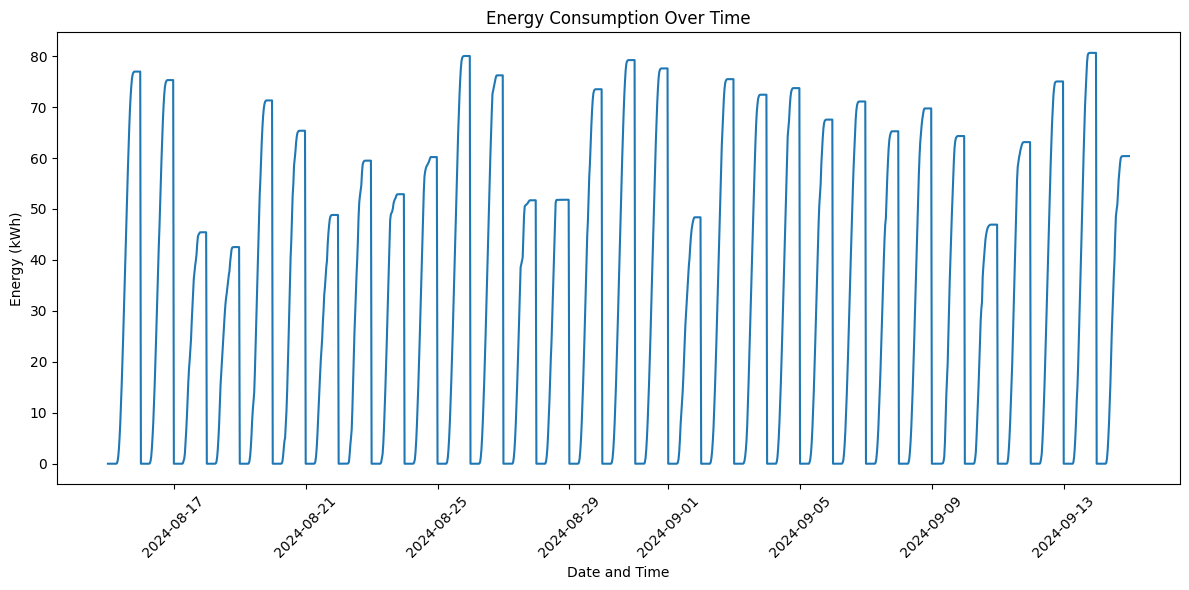

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean['Energy'])
plt.title('Energy Consumption Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [31]:
def remove_outliers(df_clean, columns):
  for column in columns:
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_clean[(df_clean[column] < lower_bound) | (df_clean[column] > upper_bound)]
    print(f"\nOutliers in {column}: {len(outliers)} rows")
    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")

    # Remove outliers
    df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]


  return df_clean


columns = list(df_clean.columns)
df_clean = remove_outliers(df_clean, columns)


Outliers in Energy: 0 rows
Lower bound: -89.709
Upper bound: 149.515

Outliers in Efficiency: 0 rows
Lower bound: -6.0592500000000005
Upper bound: 10.09875

Outliers in Power: 4 rows
Lower bound: -7461.375
Upper bound: 12435.625

Outliers in Average: 0 rows
Lower bound: -7960.5
Upper bound: 13267.5

Outliers in Normalised: 0 rows
Lower bound: -0.5373749999999999
Upper bound: 0.8956249999999999

Outliers in Temperature: 0 rows
Lower bound: 11.250000000000002
Upper bound: 38.05

Outliers in Voltage: 48 rows
Lower bound: 225.75
Upper bound: 239.75

Outliers in Energy Used: 15 rows
Lower bound: -3.0008750000000015
Upper bound: 11.100125000000002

Outliers in Power Used: 208 rows
Lower bound: 24.0
Upper bound: 600.0


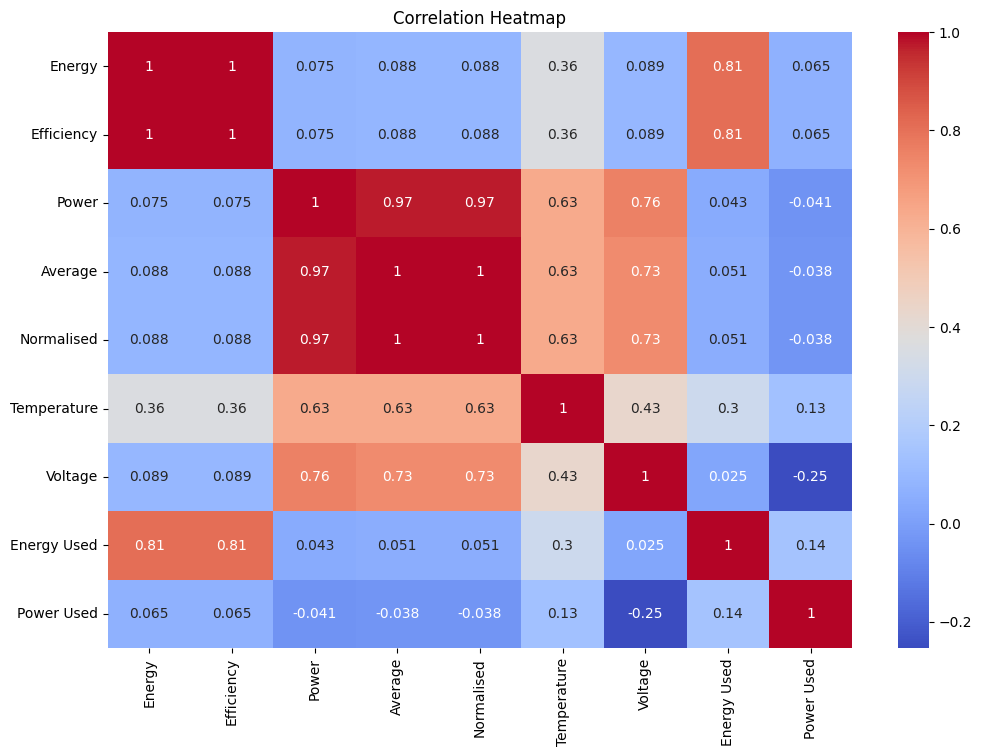

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Energy & Efficiency are perfectly correlated (1.0) - Power, Average, and Normalised are highly correlated (0.97-1.0).

Since Energy is the target varaible, efficiency will be removed.

Between Power, Avarage and Normalised, the first varabile contein the mode relevant information, hence will be kept and the other two variables too be removed.

In [32]:
df_clean = df_clean.drop(['Efficiency', 'Average', 'Normalised'] , axis=1)

In [ ]:
df_clean.head()

,Energy,Power,Temperature,Voltage,Energy Used,Power Used
DateTime,,,,,,
2024-08-15 00:00:00,0.0,0.0,24.2,229.2,0.099,228.0
2024-08-15 02:30:00,0.0,0.0,24.2,232.2,1.670,180.0
2024-08-15 03:00:00,0.0,0.0,23.6,231.9,1.753,240.0
2024-08-15 03:30:00,0.0,0.0,23.6,231.5,1.880,264.0
2024-08-15 04:00:00,0.0,0.0,23.6,232.8,2.045,264.0


In [33]:
def create_solar_lags(df_clean, columns):

    df_lagged = df_clean.copy()

    # Lag periods for 30-min intervals:
    # 1 = 30 min, 2 = 1 hour, 48 = 24 hours, 336 = 1 week
    n_lags = [1, 2, 48, 336]

    for column in columns:
        for lag in n_lags:
            df_lagged[f'{column}_lag_{lag}'] = df_lagged[column].shift(lag)

    # Remove NaN rows created by lagging
    df_lagged = df_lagged.dropna()

    print("\nCreated lags:")
    print("- 30 minutes ago (lag_1)")
    print("- 1 hour ago (lag_2)")
    print("- 24 hours ago (lag_48)")
    print("- 1 week ago (lag_336)")

    print(f"\nRows before lags: {len(df_clean)}")
    print(f"Rows after lags: {len(df_lagged)}")

    return df_lagged

# Variables to lag
lag_columns = ['Power', 'Temperature', 'Voltage', 'Power Used']  # 'Energy Used' represent cummulative energy consumption.

# Create lags
df_lagged = create_solar_lags(df_clean, columns=lag_columns)


Created lags:
- 30 minutes ago (lag_1)
- 1 hour ago (lag_2)
- 24 hours ago (lag_48)
- 1 week ago (lag_336)

Rows before lags: 1213
Rows after lags: 877


'Energy Used' represent cummulative energy consumption, it could contain information about the target varabile 'Energy' and cause data leakage, hence is not inclunded in the lag varaibles.

In [34]:
# Check the created lag columns
print("\nNew columns created:")
lag_cols = [col for col in df_lagged.columns if 'lag' in col]
print(lag_cols)

# Check final shape
print("\nFinal shape:", df_lagged.shape)


New columns created:
['Power_lag_1', 'Power_lag_2', 'Power_lag_48', 'Power_lag_336', 'Temperature_lag_1', 'Temperature_lag_2', 'Temperature_lag_48', 'Temperature_lag_336', 'Voltage_lag_1', 'Voltage_lag_2', 'Voltage_lag_48', 'Voltage_lag_336', 'Power Used_lag_1', 'Power Used_lag_2', 'Power Used_lag_48', 'Power Used_lag_336']

Final shape: (877, 22)


In [35]:
df_lagged['minute'] = df_lagged.index.minute
df_lagged['hour'] = df_lagged.index.hour
df_lagged['day'] = df_lagged.index.day

As my data are 30 minutes interval, including minutes, hour and day columns is essential.

In [ ]:
df_lagged.head()

,Energy,Power,Temperature,Voltage,Energy Used,Power Used,Power_lag_1,Power_lag_2,Power_lag_48,Power_lag_336,...,Voltage_lag_2,Voltage_lag_48,Voltage_lag_336,Power Used_lag_1,Power Used_lag_2,Power Used_lag_48,Power Used_lag_336,minute,hour,day
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-08-23 13:00:00,43.544,10989.0,32.1,239.4,3.468,168.0,10775.0,5006.0,59.0,0.0,...,235.5,230.1,229.2,264.0,240.0,348.0,228.0,0,13,23
2024-08-23 13:30:00,47.786,7045.0,30.2,238.8,3.541,144.0,10989.0,10775.0,2937.0,0.0,...,237.0,233.9,232.2,168.0,264.0,240.0,180.0,30,13,23
2024-08-23 14:00:00,48.924,1066.0,30.0,233.3,3.686,348.0,7045.0,10989.0,4137.0,0.0,...,239.4,230.9,231.9,144.0,168.0,360.0,240.0,0,14,23
2024-08-23 14:30:00,49.236,296.0,29.0,233.2,3.870,288.0,1066.0,7045.0,5660.0,0.0,...,238.8,237.7,231.5,348.0,144.0,324.0,264.0,30,14,23
2024-08-23 15:00:00,49.521,915.0,27.1,235.1,3.991,240.0,296.0,1066.0,2429.0,0.0,...,233.3,234.8,232.8,288.0,348.0,288.0,264.0,0,15,23


Split the data into training and testing sets (80% train, 20% test)

In [36]:
split_point = int(len(df_lagged) * 0.8)

# Split the data
X = df_lagged.drop('Energy', axis=1)
y = df_lagged['Energy']

# Time-based split
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]

# Print sizes
print('Training set size:', len(X_train))
print('Test set size:', len(X_test))
print('Training set date range:', X_train.index[0], 'to', X_train.index[-1])
print('Test set date range:', X_test.index[0], 'to', X_test.index[-1])

Training set size: 701
Test set size: 176
Training set date range: 2024-08-23 13:00:00 to 2024-09-10 17:30:00
Test set date range: 2024-09-10 18:00:00 to 2024-09-14 23:30:00


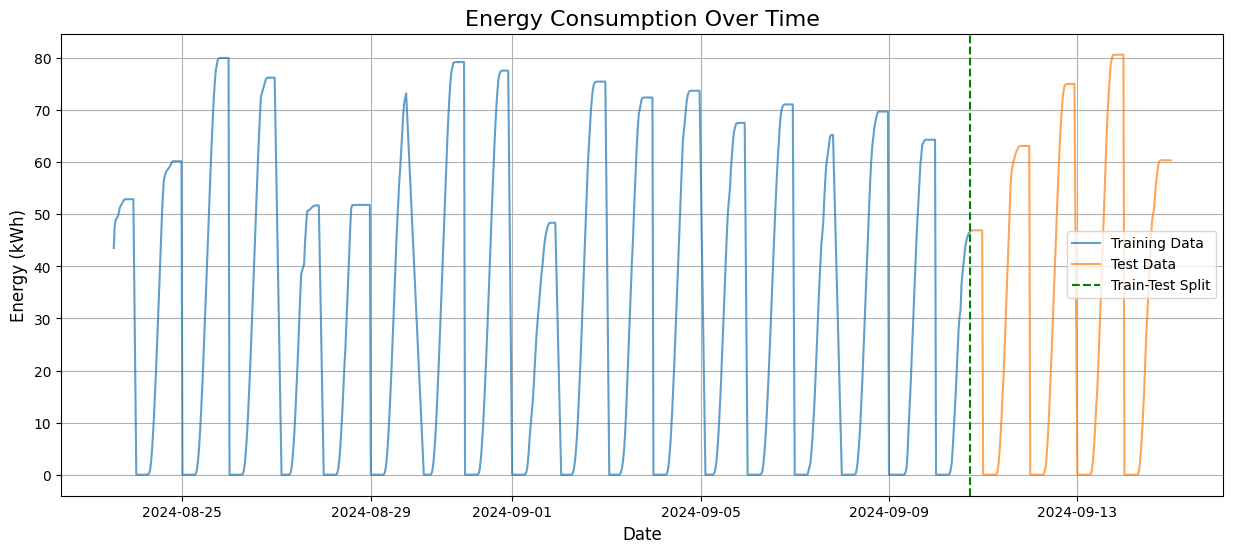

In [ ]:
# Plot target variable
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train, label='Training Data', alpha=0.7)
plt.plot(y_test.index, y_test, label='Test Data', alpha=0.7)
split_date = y_train.index[-1]
plt.axvline(x=split_date, color='green', linestyle='--', label='Train-Test Split')
plt.title('Energy Consumption Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
param_grid = {
    'max_depth': [2, 3, 4],
    'min_child_weight': [5, 6, 7],
    'subsample': [0.7 ,0.8, 0.9],
    'colsample_bytree': [0.7 ,0.8, 0.9],
    'reg_alpha': [8.5, 9.5, 10.5],
    'reg_lambda': [8.5, 9.5, 10.5],
    'gamma': [0.5, 0.7, 0.9],
    'learning_rate': [0.01, 0.02, 0.03]
}

# Create base model
model = XGBRegressor(n_estimators=100, random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters found:")
print(grid_search.best_params_)
print("\nBest RMSE:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits

Best parameters found:
{'colsample_bytree': 0.9, 'gamma': 0.5, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 7, 'reg_alpha': 8.5, 'reg_lambda': 8.5, 'subsample': 0.7}

Best RMSE: 6.975207057771544


The suggestion given from grid search offer a great RMSE but the result to be overfitting. After some tweaking I found the optimal balance between accuracy and overfitting

In [37]:
model = XGBRegressor(
    n_estimators=95,
    learning_rate=0.03,
    max_depth=2,
    min_child_weight=8,
    subsample=0.7,
    colsample_bytree=0.9,
    reg_alpha=9.5,
    reg_lambda=8.5,
    gamma=0.5,
    random_state=42,
    early_stopping_rounds=10,
    eval_metric=['rmse', 'mae']
)
# Fit the model
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Print best iteration
print("Best iteration:", model.best_iteration)

Best iteration: 94


In [38]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

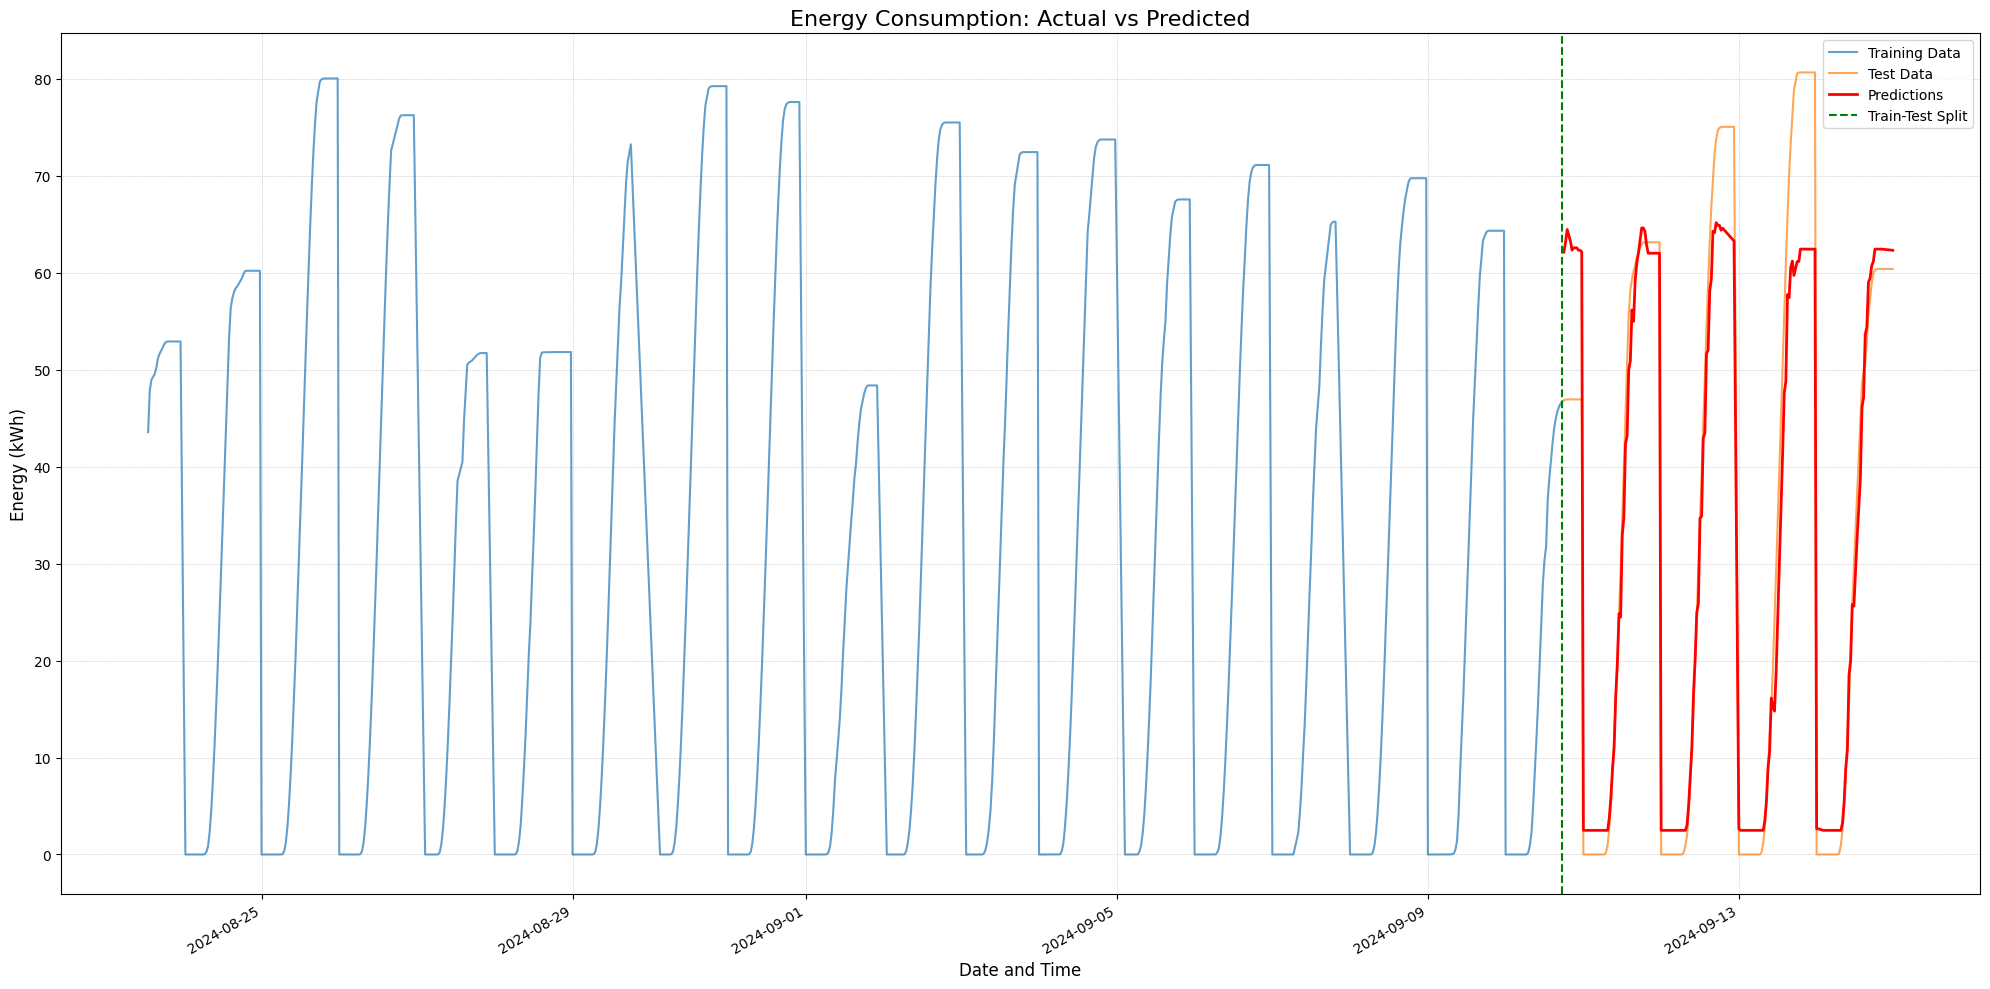

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(y_train.index, y_train, label='Training Data', alpha=0.7)
plt.plot(y_test.index, y_test, label='Test Data', alpha=0.7)
plt.plot(y_test.index, test_predictions, label='Predictions', color='red', linewidth=2)
plt.axvline(x=y_train.index[-1] , color='green', linestyle='--', label='Train-Test Split')
plt.title('Energy Consumption: Actual vs Predicted', fontsize=16)
plt.xlabel('Date and Time', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

# Format x-axis to show dates nicely
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

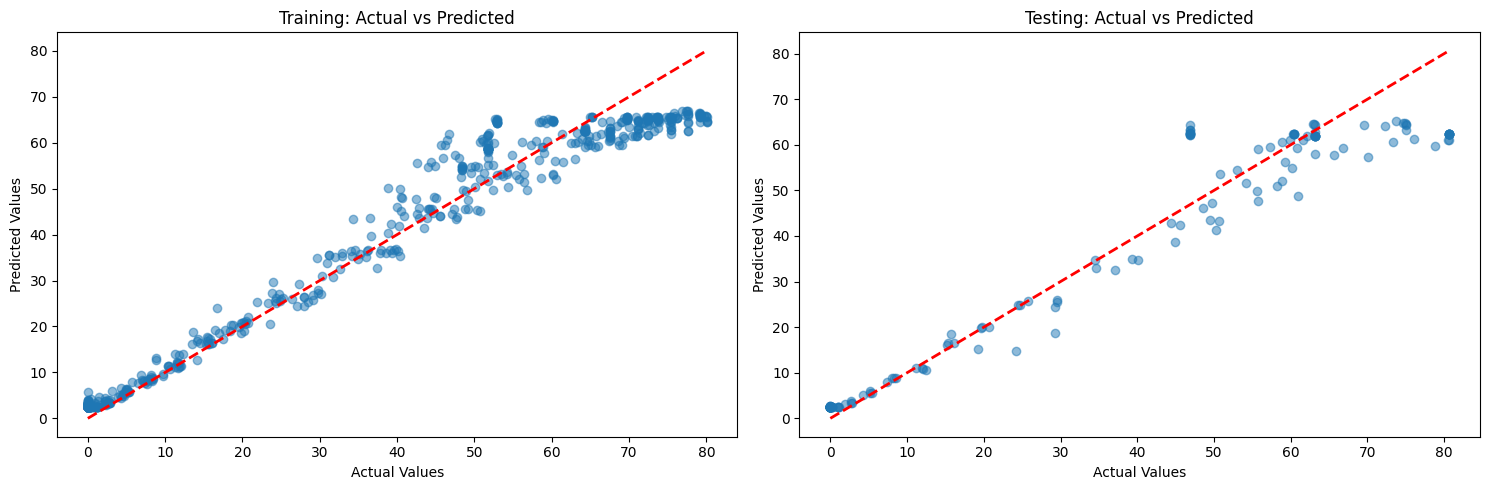

In [ ]:
# Create subplot
plt.figure(figsize=(15, 5))

# Training data plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training: Actual vs Predicted')

# Testing data plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Testing: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [41]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate MAE
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

# Calculate R2
train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"Training RMSE: {train_rmse:.2f} kWh, Test RSME: {test_rmse}")
print(f"Training MAE: {train_mae:.2f} kWh, Test MAE: {test_mae:.2f} kWh")
print(f"Train R2: {train_r2:.2f} kWh, Test R2: {test_r2}")


# Check for overfitting
print("\nOverfitting Check:")
print(f"RMSE Difference (Test - Train): {test_rmse - train_rmse}")
print(f"R2 Difference (Train - Test): {train_r2 - test_r2}")

Training RMSE: 5.55 kWh, Test RSME: 7.540337444194856
Training MAE: 4.24 kWh, Test MAE: 5.06 kWh
Train R2: 0.96 kWh, Test R2: 0.9363119901787371

Overfitting Check:
RMSE Difference (Test - Train): 1.9904719168740712
R2 Difference (Train - Test): 0.028498653004696894


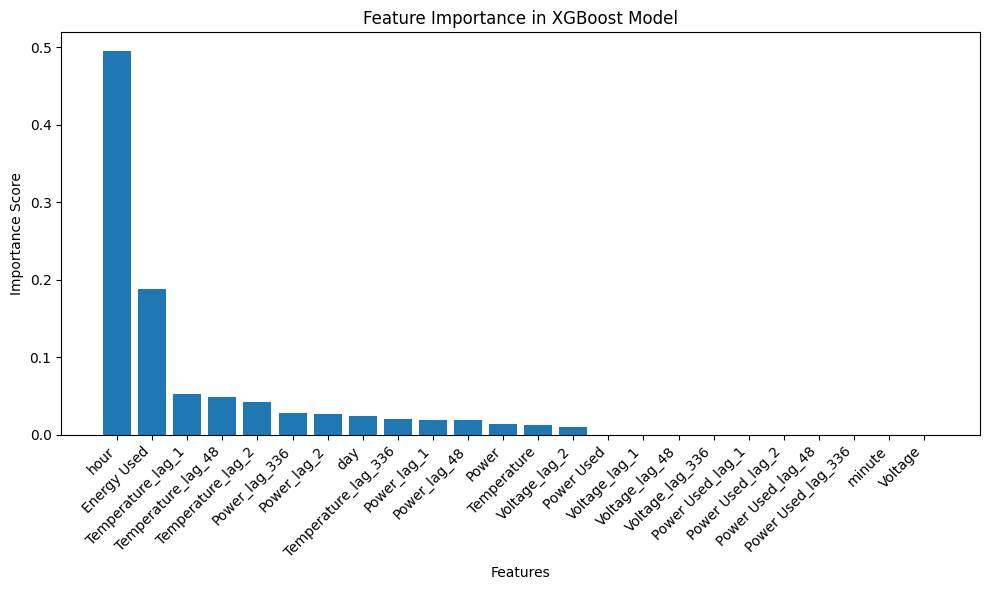


Feature Importance Rankings:
hour: 0.4948
Energy Used: 0.1887
Temperature_lag_1: 0.0523
Temperature_lag_48: 0.0491
Temperature_lag_2: 0.0421
Power_lag_336: 0.0285
Power_lag_2: 0.0266
day: 0.0241
Temperature_lag_336: 0.0202
Power_lag_1: 0.0187
Power_lag_48: 0.0186
Power: 0.0134
Temperature: 0.0131
Voltage_lag_2: 0.0098
Power Used: 0.0000
Voltage_lag_1: 0.0000
Voltage_lag_48: 0.0000
Voltage_lag_336: 0.0000
Power Used_lag_1: 0.0000
Power Used_lag_2: 0.0000
Power Used_lag_48: 0.0000
Power Used_lag_336: 0.0000
minute: 0.0000
Voltage: 0.0000


In [ ]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(importance['feature'], importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance in XGBoost Model')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

# 2. Print Feature Importance Values
print("\nFeature Importance Rankings:")
for idx, row in importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

In [42]:
# Global results
global_mae = (train_mae + test_mae) / 2
global_rmse = (train_rmse + test_rmse) / 2


print(f"Global MAE: {global_mae:.2f} kWh")
print(f"Global RMSE: {global_rmse:.2f} kWh")

Global MAE: 4.65 kWh
Global RMSE: 6.55 kWh
